# Violence Detection with MobileNetV2 with TSM

This notebook trains a MobileNetV2 model with TSM for violence detection in videos.

In [ ]:
## Change the Image size from 224x224 to 64 due to memory constraints
## Change the Sequence length 16 to 8 due to memory constraints
## Change the Batch size from 16 to 8 due to memory constraints
## Change the MAX_VIDEOS_PER_CLASS from 1000 to 500 due to memory constraints

In [1]:
# Import the 'os' module for interacting with the operating system (file/directory operations, environment variables, etc.)
import os

# Import the 'platform' module to retrieve system information (OS, hardware, Python version, etc.)
import platform

# Import the 'clear_output' function from IPython to clear the output of Jupyter notebooks dynamically
from IPython.display import clear_output

# Import 'numpy' as 'np' for numerical computations, array manipulations, and linear algebra operations
import numpy as np

# Import OpenCV ('cv2') for computer vision tasks (image/video processing, object detection, etc.)
import cv2

# Import TensorFlow for deep learning and neural network operations
import tensorflow as tf

# From TensorFlow, import Keras (high-level API for building/training neural networks)
from tensorflow import keras

# From Keras, import specific modules:
# - 'layers' for neural network layer definitions (Dense, Conv2D, etc.)
# - 'Model' for creating custom Keras models
# - 'regularizers' for applying L1/L2 regularization to layers
from keras import layers, Model, regularizers

# Import MobileNetV2 (a pre-trained CNN architecture) for transfer learning
from keras.applications import MobileNetV2

# Import Keras callbacks for model training control:
# - ModelCheckpoint: Save model weights during training
# - EarlyStopping: Stop training if validation performance plateaus
# - ReduceLROnPlateau: Reduce learning rate when validation loss stagnates
# - TensorBoard: Visualize training metrics in TensorBoard
# - LearningRateScheduler: Dynamically adjust learning rate
# - Callback: Base class for custom callbacks
from keras.callbacks import (ModelCheckpoint, EarlyStopping, 
                                       ReduceLROnPlateau, TensorBoard, 
                                       LearningRateScheduler, Callback)

# Import StratifiedShuffleSplit for stratified train-test splits (preserves class distribution)
from sklearn.model_selection import StratifiedShuffleSplit

# Import scikit-learn metrics for model evaluation (accuracy, precision, recall, etc.)
from sklearn import metrics

# Import matplotlib.pyplot as 'plt' for data visualization (plotting graphs, images, etc.)
import matplotlib.pyplot as plt

# Import seaborn as 'sns' for enhanced statistical visualizations (built on matplotlib)
import seaborn as sns

# Import tqdm for progress bars in loops (provides visual feedback for long-running operations)
from tqdm import tqdm

# Import datetime for date/time operations (e.g., timestamping logs or model saves)
import datetime

# Import subprocess for running shell commands from Python (e.g., executing system commands)
import subprocess

In [2]:
# Uncomment the following line to disable GPU support
# Sets the CUDA_VISIBLE_DEVICES environment variable to "-1", 
# which effectively hides all GPU devices from TensorFlow and forces CPU-only execution.
# This is useful for debugging or when GPU resources are unavailable/undesired.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Configure TensorFlow and GPU
# Set random seed for TensorFlow operations to ensure reproducibility
tf.random.set_seed(42)

# Configure GPU memory growth
# Get list of all available GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Iterate through each GPU and enable memory growth
        # This prevents TensorFlow from allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Print success message with GPU count
        print(f"{len(gpus)} GPU(s) found and configured.")
    except RuntimeError as e:
        # Handle errors that might occur during GPU configuration
        print("Error configuring GPU memory:", e)
else:
    # Message when no GPUs are detected
    print("No GPU found by TensorFlow.")

# Check GPU status
# Get the current operating system name
system_platform = platform.system()
# Check if OS is Linux, macOS (Darwin), or Windows
if system_platform in ['Linux', 'Darwin', 'Windows']:
    try:
        # Run nvidia-smi command to get GPU status
        result = subprocess.run(["nvidia-smi"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if result.returncode == 0:
            # Print nvidia-smi output if command succeeds
            print("nvidia-smi output:\n", result.stdout)
        else:
            # Message if nvidia-smi fails (no NVIDIA GPU or drivers)
            print("nvidia-smi not found or no NVIDIA GPU available.")
    except FileNotFoundError:
        # Handle case where nvidia-smi command doesn't exist
        print("nvidia-smi not found. Make sure NVIDIA drivers are installed.")

# Print TensorFlow version information
print("TensorFlow version:", tf.__version__)
# Print number of available GPUs
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

No GPU found by TensorFlow.
nvidia-smi output:
 Wed Jun  4 10:04:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.28                 Driver Version: 576.28         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              2W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |


In [4]:
# Print detailed system platform information including OS version and architecture
print(platform.platform())

# Helper functions for directory management

def resolve_dir(Dir):
    """
    Creates a directory if it doesn't exist.
    
    Args:
        Dir (str): Path to directory to create
    """
    # Check if directory exists
    if not os.path.exists(Dir):
        # Create directory (including any necessary parent directories)
        os.makedirs(Dir)

def reset_path(Dir):
    """
    Resets a directory by either creating it (if it doesn't exist) 
    or clearing its contents (if it exists).
    
    Args:
        Dir (str): Path to directory to reset
    """
    # Check if directory exists
    if not os.path.exists(Dir):
        # Create directory if it doesn't exist
        os.makedirs(Dir)
    else:
        # If directory exists, clear its contents
        # Iterate through all files/directories in the target directory
        for filename in os.listdir(Dir):
            # Create full path to the file/directory
            file_path = os.path.join(Dir, filename)
            try:
                # Check if it's a file (not a directory)
                if os.path.isfile(file_path):
                    # Delete the file
                    os.remove(file_path)
            except Exception as e:
                # Print error message if deletion fails
                print(f"Error deleting file {file_path}: {e}")

# Create necessary directories
# List of standard directories needed for the project
for dir_name in ['model', 'logs', 'images']:
    # Create each directory using resolve_dir()
    resolve_dir(dir_name)

Windows-10-10.0.26100-SP0


In [5]:
# Import the device_lib module from TensorFlow's Python client
# This module provides information about available computing devices
from tensorflow.python.client import device_lib

# List and print all locally available devices that TensorFlow can access
# This includes CPUs, GPUs, and other accelerators
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2950183541379329899
xla_global_id: -1
]


## Dataset Configuration

In [ ]:
# Model hyperparameters - Optimized for TSM temporal modeling

# Image dimensions for input frames (height and width in pixels)
# Standard size for many CNN architectures like MobileNetV2/ResNet 
IMG_SIZE = 64 # Standard should be 224

# Number of consecutive frames in each video sequence/clip
# TSM processes these frames to capture temporal relationships
SEQUENCE_LENGTH = 8  # Number of frames per sequence. Standard is 16.

# Number of color channels in input images (3 for RGB)
ColorChannels = 3

# Batch size for training - higher is generally better for stability
# TSM's memory efficiency allows larger batches than regular 3D CNNs
BATCH_SIZE = 8  # Increased batch size since TSM is memory efficient. Standard is 32.

# Total number of training iterations over the entire dataset
EPOCHS = 30

# TSM-specific parameter controlling how many channels get temporally shifted
# Shifts a portion of channels along temporal dimension to capture motion
TSM_SHIFT_RATIO = 0.25  # Fraction of channels to shift

In [7]:
# Base directory
# Creates a project directory path by joining the current working directory with 'data'
# os.getcwd() gets the current working directory (where the script is running from)
# os.path.join() safely combines paths in an OS-agnostic way (handles / or \ automatically)
PROJECT_DIR = os.path.join(os.getcwd(), 'data')

# Prints the full path to the dataset directory for verification
print("Dataset path:", PROJECT_DIR)

# Checks if the project directory exists
if os.path.exists(PROJECT_DIR):
    # If directory exists, list all items (subdirectories/files) in it
    # Typically these would represent class folders in a classification dataset
    print("Classes:", os.listdir(PROJECT_DIR))
else:
    # Warning message if the expected data directory isn't found
    print("Warning: Data directory not found!")

Dataset path: c:\Users\USER\Documents\GitHub\CCDEPLRL_PROJECT\data
Classes: ['NonViolence', 'Violence']


In [8]:
def extract_frames_from_video(video_path, max_frames=None):
    """Extract frames from video with improved sampling
    
    Args:
        video_path (str): Path to the input video file
        max_frames (int, optional): Maximum number of frames to extract. 
                                  If None, extracts every 3rd frame.
    
    Returns:
        numpy.ndarray: Array of extracted frames in RGB format with shape (N, H, W, C)
    """
    # Initialize empty list to store extracted frames
    frames = []
    
    # Open video file using OpenCV's VideoCapture
    vidcap = cv2.VideoCapture(video_path)
    
    # Get video properties
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total frames in video
    fps = vidcap.get(cv2.CAP_PROP_FPS)  # Frames per second
    
    # Determine frame sampling strategy
    if max_frames and total_frames > max_frames:
        # When max_frames is specified and video has more frames:
        # Create evenly spaced frame indices across the entire video
        frame_indices = np.linspace(0, total_frames - 1, max_frames, dtype=int)
    else:
        # Default case: Sample every 3rd frame to reduce redundancy
        frame_indices = range(0, total_frames, 3)
    
    # Initialize video reading variables
    success = True  # Flag for successful frame read
    frame_count = 0  # Current frame counter
    
    # Read video frame by frame
    while success and frame_count < total_frames:
        # Read next frame
        success, image = vidcap.read()
        
        # Process frame if reading was successful and it's in our target indices
        if success and frame_count in frame_indices:
            # Convert from BGR (OpenCV default) to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Resize frame to match model's expected input size
            image_resized = cv2.resize(image_rgb, (IMG_SIZE, IMG_SIZE))
            
            # Add processed frame to our list
            frames.append(image_resized)
        
        # Increment frame counter
        frame_count += 1
    
    # Release video file handle
    vidcap.release()
    
    # Convert list of frames to numpy array and return
    return np.array(frames)

## Prepare Sequencing of Frames


In [9]:
def create_sequences(frames, sequence_length=SEQUENCE_LENGTH):
    """Create sequences of frames for temporal analysis
    
    Args:
        frames (np.ndarray): Array of video frames with shape (N, H, W, C)
        sequence_length (int): Desired length of output sequences
        
    Returns:
        np.ndarray: Array of sequences with shape (M, sequence_length, H, W, C)
                   where M is the number of generated sequences
    """
    
    sequences = []  # Initialize empty list to store sequences
    
    # Case 1: Not enough frames for a full sequence
    if len(frames) < sequence_length:
        # Calculate how many padding frames we need
        padding_needed = sequence_length - len(frames)
        
        if len(frames) > 0:  # If we have some frames
            # Pad with duplicates of the last frame
            padded_frames = np.concatenate([
                frames,  # Original frames
                np.repeat(frames[-1:], padding_needed, axis=0)  # Repeated last frame
            ])
        else:  # If no frames available at all
            # Create black frames as padding
            padded_frames = np.zeros((
                sequence_length,  # Number of frames
                IMG_SIZE,        # Height
                IMG_SIZE,        # Width 
                ColorChannels    # Channels (3 for RGB)
            ))
        
        sequences.append(padded_frames)
    
    # Case 2: Enough frames available
    else:
        # Create sequences with 50% overlap between consecutive sequences
        for i in range(0, len(frames) - sequence_length + 1, sequence_length // 2):
            # Extract a sequence of the specified length
            sequence = frames[i:i + sequence_length]
            sequences.append(sequence)
    
    return np.array(sequences)

## Load and Prepare Dataset

In [ ]:
# Load and process data with sequence creation
print("Loading and processing video data...")

# Define data directory and classes
VideoDataDir = PROJECT_DIR  # Base directory containing class folders
CLASSES = ["NonViolence", "Violence"]  # Binary classification categories
MAX_VIDEOS_PER_CLASS = 500  # Limit to prevent memory issues. Standard is 1000.

# Initialize empty lists for sequences and labels
X_sequences = []  # Will store video sequences
y_sequences = []  # Will store corresponding labels

# Process each class (Violence/NonViolence)
for category in CLASSES:
    # Construct full path to class directory
    path = os.path.join(VideoDataDir, category)
    
    # Skip if directory doesn't exist
    if not os.path.exists(path):
        print(f"Warning: Directory {path} does not exist!")
        continue
        
    print(f"Processing {category} data...")
    class_num = CLASSES.index(category)  # Get class index (0 or 1)
    
    # Get all image files in directory (assuming extracted frames)
    image_files = [f for f in os.listdir(path) 
                 if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    # Skip if no images found
    if not image_files:
        print(f"No image files found in {path}")
        continue
    
    # Group images by video source (assumes filename format: videoName-frameNumber.ext)
    video_groups = {}
    for img_file in image_files:
        video_name = img_file.split('-')[0]  # Extract video name before first hyphen
        if video_name not in video_groups:
            video_groups[video_name] = []
        video_groups[video_name].append(img_file)
    
    # Process each video's frames
    processed_videos = 0
    for video_name, img_files in tqdm(video_groups.items(),
                                    desc=f"Processing {category} videos"):
        # Stop if we've reached maximum videos per class
        if processed_videos >= MAX_VIDEOS_PER_CLASS:
            break
            
        # Sort frames by their number (assumes format videoName-frameNumber.ext)
        img_files.sort(key=lambda x: int(x.split('-')[1].split('.')[0]))
        
        # Load and preprocess all frames for this video
        frames = []
        for img_file in img_files:
            img_path = os.path.join(path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is not None:  # Only process if image loaded successfully
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))  # Resize
                    frames.append(img_resized)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
        
        # Only proceed if we got valid frames
        if len(frames) > 0:
            # Convert frames to sequences using our sequence creation function
            sequences = create_sequences(np.array(frames))
            
            # Add sequences and corresponding labels to our dataset
            for sequence in sequences:
                X_sequences.append(sequence)
                y_sequences.append(class_num)
            
            processed_videos += 1

# Final dataset preparation
X_sequences = np.array(X_sequences, dtype=np.float32) / 255.0  # Normalize to [0,1]
y_sequences = np.array(y_sequences)  # Convert labels to numpy array

# Print dataset statistics
print(f"Total sequences: {len(X_sequences)}")
print(f"Sequence shape: {X_sequences.shape}")  # Expected: (N, SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, 3)
print(f"Labels shape: {y_sequences.shape}")  # Expected: (N,)

Loading and processing video data...
Processing NonViolence data...


Processing NonViolence videos:  50%|█████     | 500/1000 [03:25<03:25,  2.43it/s]


Processing Violence data...


Processing Violence videos:  50%|█████     | 500/1000 [05:54<05:54,  1.41it/s]  


Total sequences: 9752
Sequence shape: (9752, 8, 64, 64, 3)
Labels shape: (9752,)


## Split Data into Training and Testing Sets

In [11]:
# Split data with stratification
# Create a stratified shuffle split object that:
# - Performs 1 split (n_splits=1)
# - Allocates 20% to test set (test_size=0.2)
# - Uses fixed random state for reproducibility (random_state=42)
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Execute the split - this generates indices for training and test sets
# The split maintains the same class distribution in both sets
for train_idx, test_idx in stratified_split.split(X_sequences, y_sequences):
    # Use the indices to partition the data
    X_train = X_sequences[train_idx]  # Training sequences (80%)
    X_test = X_sequences[test_idx]    # Test sequences (20%)
    y_train = y_sequences[train_idx]  # Training labels
    y_test = y_sequences[test_idx]    # Test labels

# Print dataset statistics
print(f"Training sequences: {X_train.shape}")  # Expected: (N*0.8, SEQUENCE_LENGTH, H, W, 3)
print(f"Testing sequences: {X_test.shape}")    # Expected: (N*0.2, SEQUENCE_LENGTH, H, W, 3)

Training sequences: (7801, 8, 64, 64, 3)
Testing sequences: (1951, 8, 64, 64, 3)


## TSM Implementation

In [12]:
class TemporalShift(layers.Layer):
    """Temporal Shift Module (TSM) implementation
    
    Key Features:
    - Lightweight temporal modeling without 3D convolutions
    - Shifts portions of channels forward/backward in time
    - Maintains spatial dimensions while capturing motion
    """
    
    def __init__(self, n_segment=8, n_div=8, shift_ratio=0.25, **kwargs):
        """
        Initialize TSM layer
        
        Args:
            n_segment: Number of temporal segments (unused in this implementation)
            n_div: Number of divisions for shift (unused here)
            shift_ratio: Fraction of channels to shift (default 25%)
        """
        super(TemporalShift, self).__init__(**kwargs)
        self.n_segment = n_segment  # Could be used for segment-based shifting
        self.n_div = n_div          # Could split channels into groups
        self.shift_ratio = shift_ratio  # % of channels to temporally shift
        
    def build(self, input_shape):
        """Layer build method (no trainable weights needed)"""
        super(TemporalShift, self).build(input_shape)
        
    def call(self, x):
        """
        Apply temporal shift operation
        
        Args:
            x: Input tensor (batch, time, height, width, channels)
            
        Returns:
            Tensor with shifted channels (same shape as input)
        """
        # Get dynamic tensor dimensions
        batch_size = tf.shape(x)[0]  # Batch dimension
        time_steps = tf.shape(x)[1]  # Temporal dimension
        height = tf.shape(x)[2]      # Spatial height
        width = tf.shape(x)[3]       # Spatial width
        channels = tf.shape(x)[4]    # Channel depth
        
        # Calculate how many channels to shift (25% by default)
        n_channels_shift = tf.cast(
            tf.cast(channels, tf.float32) * self.shift_ratio, 
            tf.int32
        )
        # Split shifted channels into forward/backward groups
        n_channels_shift_forward = n_channels_shift // 2
        n_channels_shift_backward = n_channels_shift - n_channels_shift_forward
        
        # Split input tensor into three parts:
        shift_forward = x[..., :n_channels_shift_forward]  # Channels to shift forward
        shift_backward = x[..., n_channels_shift_forward:n_channels_shift]  # Channels to shift backward
        no_shift = x[..., n_channels_shift:]  # Channels to leave unchanged
        
        # Apply temporal shifts with padding:
        # Forward shift: move features from t-1 to t (right shift)
        shift_forward_padded = tf.pad(
            shift_forward[:, :-1],  # Remove last frame
            [[0, 0], [1, 0], [0, 0], [0, 0], [0, 0]],  # Pad at beginning
            'CONSTANT'
        )
        
        # Backward shift: move features from t+1 to t (left shift)
        shift_backward_padded = tf.pad(
            shift_backward[:, 1:],   # Remove first frame
            [[0, 0], [0, 1], [0, 0], [0, 0], [0, 0]],  # Pad at end
            'CONSTANT'
        )
        
        # Recombine all channels
        shifted_x = tf.concat([
            shift_forward_padded,    # Forward shifted channels
            shift_backward_padded,   # Backward shifted channels
            no_shift                # Unshifted channels
        ], axis=-1)
        
        return shifted_x
    
    def compute_output_shape(self, input_shape):
        """Output shape matches input shape"""
        return input_shape
    
    def get_config(self):
        """Serialization config for model saving"""
        config = super(TemporalShift, self).get_config()
        config.update({
            'n_segment': self.n_segment,
            'n_div': self.n_div,
            'shift_ratio': self.shift_ratio
        })
        return config

## Define and Build the MobileNetV2 Model with TSM Integration


In [13]:
def create_tsm_mobilenetv2_backbone():
    """Create MobileNetV2 backbone with TSM integration
    
    Returns:
        Model: A modified MobileNetV2 model prepared for TSM integration
    """
    
    # Create base MobileNetV2 model
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, ColorChannels),  # Input shape (224,224,3)
        include_top=False,             # Exclude classification head
        weights='imagenet',            # Pre-trained on ImageNet
        alpha=1.0                      # Width multiplier (1.0 = original)
    )
    
    # Strategic positions to insert TSM layers
    tsm_positions = [
        'block_1_expand_relu',   # Early features (shallow layer)
        'block_6_expand_relu',   # Mid-level features
        'block_13_expand_relu',  # High-level features (deep layer)
    ]
    
    # Rebuild model with TSM integration points
    x = base_model.input  # Start with input tensor
    
    for layer in base_model.layers[1:]:  # Skip input layer
        if layer.name in tsm_positions:
            # Apply the original layer first
            x = layer(x)
            # Note: Actual TSM application happens later when we have temporal dimension
            # We're marking these layers for later TSM processing
        else:
            # Standard layer processing
            x = layer(x)
    
    # Create the modified backbone model
    tsm_backbone = Model(
        inputs=base_model.input, 
        outputs=x, 
        name='tsm_mobilenetv2_backbone'
    )
    
    return tsm_backbone

## Build a model combining MobileNetV2 feature extraction with TSM temporal modeling

In [14]:
def build_mobilenetv2_tsm_model():
    """Build a model combining MobileNetV2 feature extraction with TSM temporal modeling
    
    Returns:
        model: Complete compiled TSM model
        mobilenet_base: The base MobileNetV2 feature extractor
    """
    
    # Input layer for video sequences (shape: batch, timesteps, height, width, channels)
    sequence_input = layers.Input(shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, ColorChannels))
    
    # Initialize MobileNetV2 base model (pretrained on ImageNet)
    mobilenet_base = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, ColorChannels),  # Single frame input shape
        include_top=False,       # Exclude classification head
        weights='imagenet',      # Use pretrained weights
        pooling=None,            # No pooling yet (we'll add later)
        alpha=1.0               # Full width version
    )
    
    # Freeze base model weights initially (can be unfrozen later)
    mobilenet_base.trainable = False
    
    # Process each frame independently using TimeDistributed wrapper
    # Output shape: (batch_size, SEQUENCE_LENGTH, height, width, channels)
    encoded_frames = layers.TimeDistributed(mobilenet_base)(sequence_input)
    
    # Apply Temporal Shift Module (TSM) to capture temporal relationships
    # Shifts channels forward/backward in time dimension
    tsm_features = TemporalShift(
        n_segment=SEQUENCE_LENGTH,  # Number of frames
        shift_ratio=TSM_SHIFT_RATIO  # Fraction of channels to shift (0.25)
    )(encoded_frames)
    
    # Reduce spatial dimensions while preserving temporal dimension
    # Shape becomes: (batch_size, SEQUENCE_LENGTH, channels)
    pooled_features = layers.TimeDistributed(
        layers.GlobalAveragePooling2D()  # Spatial pooling
    )(tsm_features)
    
    # Temporal Convolutional Layers
    # First 1D convolution with larger kernel to capture longer patterns
    temporal_conv1 = layers.Conv1D(
        filters=512,               # High-dimensional temporal features
        kernel_size=5,             # 5-frame temporal context
        activation='relu',
        padding='same',            # Maintain sequence length
        kernel_regularizer=regularizers.l2(0.001)  # L2 regularization
    )(pooled_features)
    temporal_conv1 = layers.BatchNormalization()(temporal_conv1)
    temporal_conv1 = layers.Dropout(0.3)(temporal_conv1)  # Regularization
    
    # Second 1D convolution with smaller kernel
    temporal_conv2 = layers.Conv1D(
        filters=256,               # Reduced feature dimension
        kernel_size=3,             # 3-frame temporal context
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(0.001)
    )(temporal_conv1)
    temporal_conv2 = layers.BatchNormalization()(temporal_conv2)
    temporal_conv2 = layers.Dropout(0.3)(temporal_conv2)
    
    # Global temporal pooling
    global_avg_pool = layers.GlobalAveragePooling1D()(temporal_conv2)
    
    # Attention Mechanism
    # Learn importance weights for each timestep
    attention_weights = layers.Dense(SEQUENCE_LENGTH, activation='softmax')(global_avg_pool)
    attention_weights = layers.Reshape((SEQUENCE_LENGTH, 1))(attention_weights)
    
    # Apply attention to original pooled features
    attended_features = layers.Multiply()([pooled_features, attention_weights])
    attended_features = layers.GlobalAveragePooling1D()(attended_features)
    
    # Combine global and attended features
    combined_features = layers.Concatenate()([global_avg_pool, attended_features])
    
    # Classification Head
    dense1 = layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    )(combined_features)
    dropout1 = layers.Dropout(0.5)(dense1)  # Higher dropout for final layers
    
    dense2 = layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    )(dropout1)
    dropout2 = layers.Dropout(0.3)(dense2)
    
    # Binary classification output
    output = layers.Dense(1, activation='sigmoid')(dropout2)
    
    # Create complete model
    model = Model(inputs=sequence_input, outputs=output)
    
    return model, mobilenet_base

## Build and Compile the Model

In [15]:
# Build the model
print("Building MobileNetV2 + TSM model...")
# Create the model architecture by calling our builder function
# Returns:
# - model: The complete TSM-enhanced classification model
# - mobilenet_base: The underlying MobileNetV2 feature extractor
model, mobilenet_base = build_mobilenetv2_tsm_model()

# Compile model with carefully tuned optimizer settings
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.0001,  # Lower initial learning rate for fine-tuning
        beta_1=0.9,           # Exponential decay rate for 1st moment estimates
        beta_2=0.999,         # Exponential decay rate for 2nd moment estimates
        epsilon=1e-7          # Small constant for numerical stability
    ),
    loss='binary_crossentropy',  # Standard loss for binary classification
    metrics=[
        'accuracy',       # Overall correctness
        'precision',      # True positives / (true positives + false positives)
        'recall'          # True positives / (true positives + false negatives)
    ]
)

print("Model compiled successfully!")
# Print model architecture summary showing:
# - Layer stack with output shapes
# - Parameter counts
# - Trainable status
model.summary()

Building MobileNetV2 + TSM model...
Model compiled successfully!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 64, 64,   0           []                               
                                3)]                                                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 8, 2, 2, 128  2257984    ['input_1[0][0]']                
 ted)                           0)                                                                
                                                                                                  
 temporal_shift (TemporalShift)  (None, 8, 2, 2, 128  0          ['time_distributed[0][0]']       
                             

## Advanced learning rate scheduling

In [16]:
def cosine_annealing_with_warmup(epoch, warmup_epochs=5, total_epochs=EPOCHS,
                                min_lr=1e-6, max_lr=1e-3):
    """Cosine annealing with warmup learning rate scheduler
    
    Args:
        epoch (int): Current epoch number (0-indexed)
        warmup_epochs (int): Number of warmup epochs
        total_epochs (int): Total training epochs
        min_lr (float): Minimum learning rate
        max_lr (float): Maximum learning rate
        
    Returns:
        float: Computed learning rate for the current epoch
    """
    
    # Warmup Phase (linear increase)
    if epoch < warmup_epochs:
        # Linearly interpolate between min_lr and max_lr
        # Formula: lr = min_lr + (max_lr - min_lr) * (epoch / warmup_epochs)
        return min_lr + (max_lr - min_lr) * epoch / warmup_epochs
    
    # Cosine Annealing Phase
    else:
        # Calculate progress through annealing phase (0 to 1)
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        
        # Cosine annealing formula:
        # lr = min_lr + (max_lr - min_lr) * 0.5 * (1 + cos(π * progress))
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * progress))

## Custom callback for model unfreezing

In [17]:
class GradualUnfreezing(Callback):
    """Gradually unfreeze MobileNetV2 layers during training
    
    This callback implements a transfer learning strategy where:
    1. The base model (MobileNetV2) starts completely frozen
    2. After specified epoch, unfreezes all base model layers
    3. Automatically reduces learning rate for fine-tuning
    
    Args:
        mobilenet_base: The MobileNetV2 base model to unfreeze
        unfreeze_epoch: Epoch number to trigger unfreezing
    """
    
    def __init__(self, mobilenet_base, unfreeze_epoch=15):
        super().__init__()
        self.mobilenet_base = mobilenet_base  # Reference to base model
        self.unfreeze_epoch = unfreeze_epoch  # When to unfreeze
        self.unfrozen = False  # Track unfreezing status
    
    def on_epoch_begin(self, epoch, logs=None):
        """Called at the start of each epoch"""
        if epoch == self.unfreeze_epoch and not self.unfrozen:
            # Unfreeze all MobileNetV2 layers
            print(f"\nUnfreezing MobileNetV2 layers at epoch {epoch}")
            self.mobilenet_base.trainable = True
            
            # Reduce learning rate for fine-tuning
            self.model.optimizer.learning_rate = 1e-5  # Lower LR
            self.unfrozen = True  # Mark as unfrozen
            
            # Recompile is not needed in modern TF versions

## Enhanced early stopping callback

In [18]:
class EnhancedEarlyStopping(Callback):
    """Enhanced early stopping with accuracy threshold
    
    Combines traditional loss-based early stopping with accuracy-based termination.
    Stops training when either:
    1. Validation accuracy reaches specified threshold (primary)
    2. Validation loss fails to improve for 'patience' epochs (secondary)
    
    Args:
        patience: Number of epochs to wait before stopping if no improvement
        min_delta: Minimum change in loss to qualify as improvement
        accuracy_threshold: Target accuracy to trigger immediate stop
    """
    
    def __init__(self, patience=10, min_delta=0.001, accuracy_threshold=0.98):
        super().__init__()
        self.patience = patience          # Epochs to wait before stopping
        self.min_delta = min_delta        # Minimum significant improvement
        self.accuracy_threshold = accuracy_threshold  # Target accuracy
        self.best_loss = np.inf           # Track best loss value
        self.wait = 0                     # Count epochs without improvement
        self.best_weights = None          # Store best model weights
    
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')          # Current validation loss
        current_accuracy = logs.get('val_accuracy')  # Current validation accuracy
        
        # Primary Stopping Condition: Accuracy Threshold
        if current_accuracy and current_accuracy >= self.accuracy_threshold:
            print(f"\nAccuracy threshold {self.accuracy_threshold} reached! Stopping training.")
            self.model.stop_training = True
            return
        
        # Secondary Stopping Condition: Loss-based Early Stopping
        if current_loss < self.best_loss - self.min_delta:
            # Significant improvement found
            self.best_loss = current_loss
            self.wait = 0
            self.best_weights = self.model.get_weights()  # Save best weights
        else:
            # No improvement
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nEarly stopping at epoch {epoch + 1}")
                if self.best_weights is not None:
                    self.model.set_weights(self.best_weights)  # Restore best weights
                self.model.stop_training = True

## Setup callbacks

In [19]:
# Create a log directory path with current timestamp for TensorBoard logs
# Format: logs/fit/YYYYMMDD-HHMMSS
log_dir = f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

# Path to save the best model weights during training
checkpoint_path = 'model/best_mobilenetv2_tsm_weights.h5'

# Path to save the final trained model
model_save_path = 'model/mobilenetv2_tsm_model.h5'

# List of callback functions to be used during model training
callbacks = [
    # Learning rate scheduling callback using cosine annealing with warmup
    # Verbose=1 prints updates when the learning rate changes
    LearningRateScheduler(cosine_annealing_with_warmup, verbose=1),
    
    # Callback to save the model weights at checkpoints
    ModelCheckpoint(
        filepath=checkpoint_path,  # Path to save weights
        monitor='val_loss',       # Metric to monitor for saving
        save_best_only=True,      # Only save if metric improves
        save_weights_only=True,   # Save only weights, not full model
        mode='min',               # Minimize the monitored metric (val_loss)
        verbose=1                 # Print messages when saving occurs
    ),
    
    # Custom early stopping callback with enhanced features:
    # - patience: wait 12 epochs without improvement
    # - min_delta: minimum change to qualify as improvement
    # - accuracy_threshold: stop if accuracy reaches 95%
    EnhancedEarlyStopping(patience=12, min_delta=0.001, accuracy_threshold=0.95),
    
    # Callback to reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',  # Metric to monitor
        factor=0.5,         # Reduce LR by half when triggered
        patience=5,         # Wait 5 epochs before reducing
        min_lr=1e-7,        # Minimum learning rate allowed
        verbose=1           # Print messages when LR changes
    ),
    
    # Callback for TensorBoard visualization
    TensorBoard(
        log_dir=log_dir,        # Directory to save logs
        histogram_freq=1,       # Compute weight histograms every epoch
        write_graph=True,       # Write the model graph to TensorBoard
        write_images=True       # Write model weights as images
    ),
    
    # Custom callback for gradual unfreezing of model layers
    # mobilenet_base: the base model to unfreeze
    # unfreeze_epoch: epoch number to start unfreezing layers
    GradualUnfreezing(mobilenet_base, unfreeze_epoch=15)
]

## Train and Save the Model

In [21]:
from keras.metrics import Precision, Recall

# Define your metrics properly
metrics = [
    'accuracy',
    Precision(name='precision'),  # Properly initialized precision metric
    Recall(name='recall')        # Properly initialized recall metric
]

# Recompile the model with correct metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    ),
    loss='binary_crossentropy',
    metrics=metrics
)

# Print training initiation message
print("Starting training...")

# Display dataset sizes for training and validation
print(f"Training with {len(X_train)} sequences, validating with {len(X_test)} sequences")

# Train the model using the fit() method
history = model.fit(
    X_train, y_train,            # Training data and labels
    epochs=EPOCHS,               # Number of training epochs
    batch_size=BATCH_SIZE,       # Number of samples per gradient update
    validation_data=(X_test, y_test),  # Validation data tuple (X_test, y_test)
    callbacks=callbacks,         # List of callbacks defined earlier
    verbose=1                    # Show progress bar and metrics (1 = progress bar)
)

# Print message indicating loading of best weights
print("Loading best weights...")

# Load the best weights saved by ModelCheckpoint callback
model.load_weights(checkpoint_path)

# Save the entire model (architecture + weights + optimizer state)
model.save(model_save_path)

# Print confirmation of model saving
print(f"Model saved to {model_save_path}")

# Initialize TFLite converter with the trained Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable these options to handle unsupported ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops fallback
]

converter._experimental_lower_tensor_list_ops = False  # Disable tensor list lowering
# Convert the model to TFLite format
tflite_model = converter.convert()

# Save the converted TFLite model to disk
with open('model/violence_model.tflite', 'wb') as f:  # 'wb' for binary write mode
    f.write(tflite_model)  # Write the TFLite model bytes to file

Starting training...
Training with 7801 sequences, validating with 1951 sequences

Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/30
976/976 [==============================] - ETA: 0s - loss: 2.3685 - accuracy: 0.5483 - precision: 0.6100 - recall: 0.6280
Epoch 1: val_loss improved from inf to 2.31775, saving model to model\best_mobilenetv2_tsm_weights.h5
976/976 [==============================] - 221s 222ms/step - loss: 2.3685 - accuracy: 0.5483 - precision: 0.6100 - recall: 0.6280 - val_loss: 2.3177 - val_accuracy: 0.7078 - val_precision: 0.6929 - val_recall: 0.8973 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 0.0009972636920218205.
Epoch 2/30
976/976 [==============================] - ETA: 0s - loss: 1.4347 - accuracy: 0.8621 - precision: 0.8774 - recall: 0.8878
Epoch 2: val_loss improved from 2.31775 to 0.90592, saving model to model\best_mobilenetv2_tsm_weights.h5
976/976 [==============================] - 198s 203ms/step - loss:

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpdb_ve0mp\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpdb_ve0mp\assets


## Evaluate the Model

In [22]:
# Define function to visualize training history with matplotlib
# save_dir: directory to save the visualization images (default='images')
def plot_training_history(history, save_dir='images'):
    """Plot training history with enhanced visualization"""
    
    # Create 2x2 grid of subplots with specified figure size (15x12 inches)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # --- Loss Subplot (Top-left) ---
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()  # Show legend with labels
    axes[0, 0].grid(True, alpha=0.3)  # Add semi-transparent grid
    
    # --- Accuracy Subplot (Top-right) ---
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # --- Precision Subplot (Bottom-left) ---
    # Only plot if precision was tracked during training
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
        axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # --- Recall Subplot (Bottom-right) ---
    # Only plot if recall was tracked during training
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
        axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    # Adjust subplot spacing for clean layout
    plt.tight_layout()
    
    # Save figure as high-res PNG (300dpi) with tight bounding box
    plt.savefig(os.path.join(save_dir, 'training_history_tsm.png'), dpi=300, bbox_inches='tight')
    
    # Display the figure
    plt.show()

# --- Model Evaluation Section ---
print("Evaluating model...")

# Evaluate model on test data, returning multiple metrics
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=1)

# Print formatted test results
print(f"\nTest Results:")
print(f"Loss: {test_loss:.4f}")         # Format to 4 decimal places
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

Evaluating model...
61/61 [==============================] - 32s 513ms/step - loss: 0.3861 - accuracy: 0.9692 - precision: 0.9679 - recall: 0.9798

Test Results:
Loss: 0.3861
Accuracy: 0.9692
Precision: 0.9679
Recall: 0.9798


## Generate Detailed Metrics

F1 Score: 0.9738
Generating predictions...
244/244 [==============================] - 34s 133ms/step


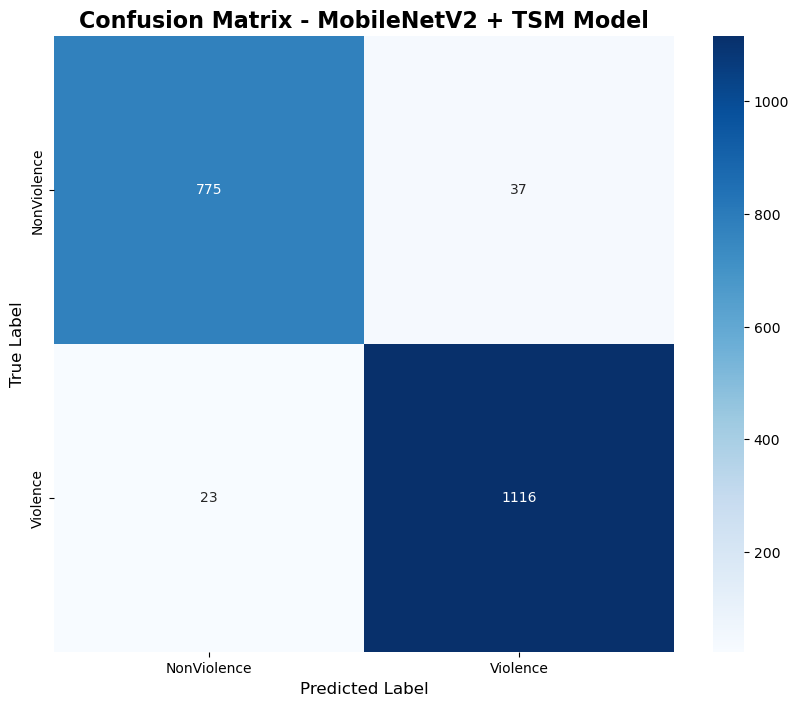


Classification Report:
              precision    recall  f1-score   support

 NonViolence       0.97      0.95      0.96       812
    Violence       0.97      0.98      0.97      1139

    accuracy                           0.97      1951
   macro avg       0.97      0.97      0.97      1951
weighted avg       0.97      0.97      0.97      1951



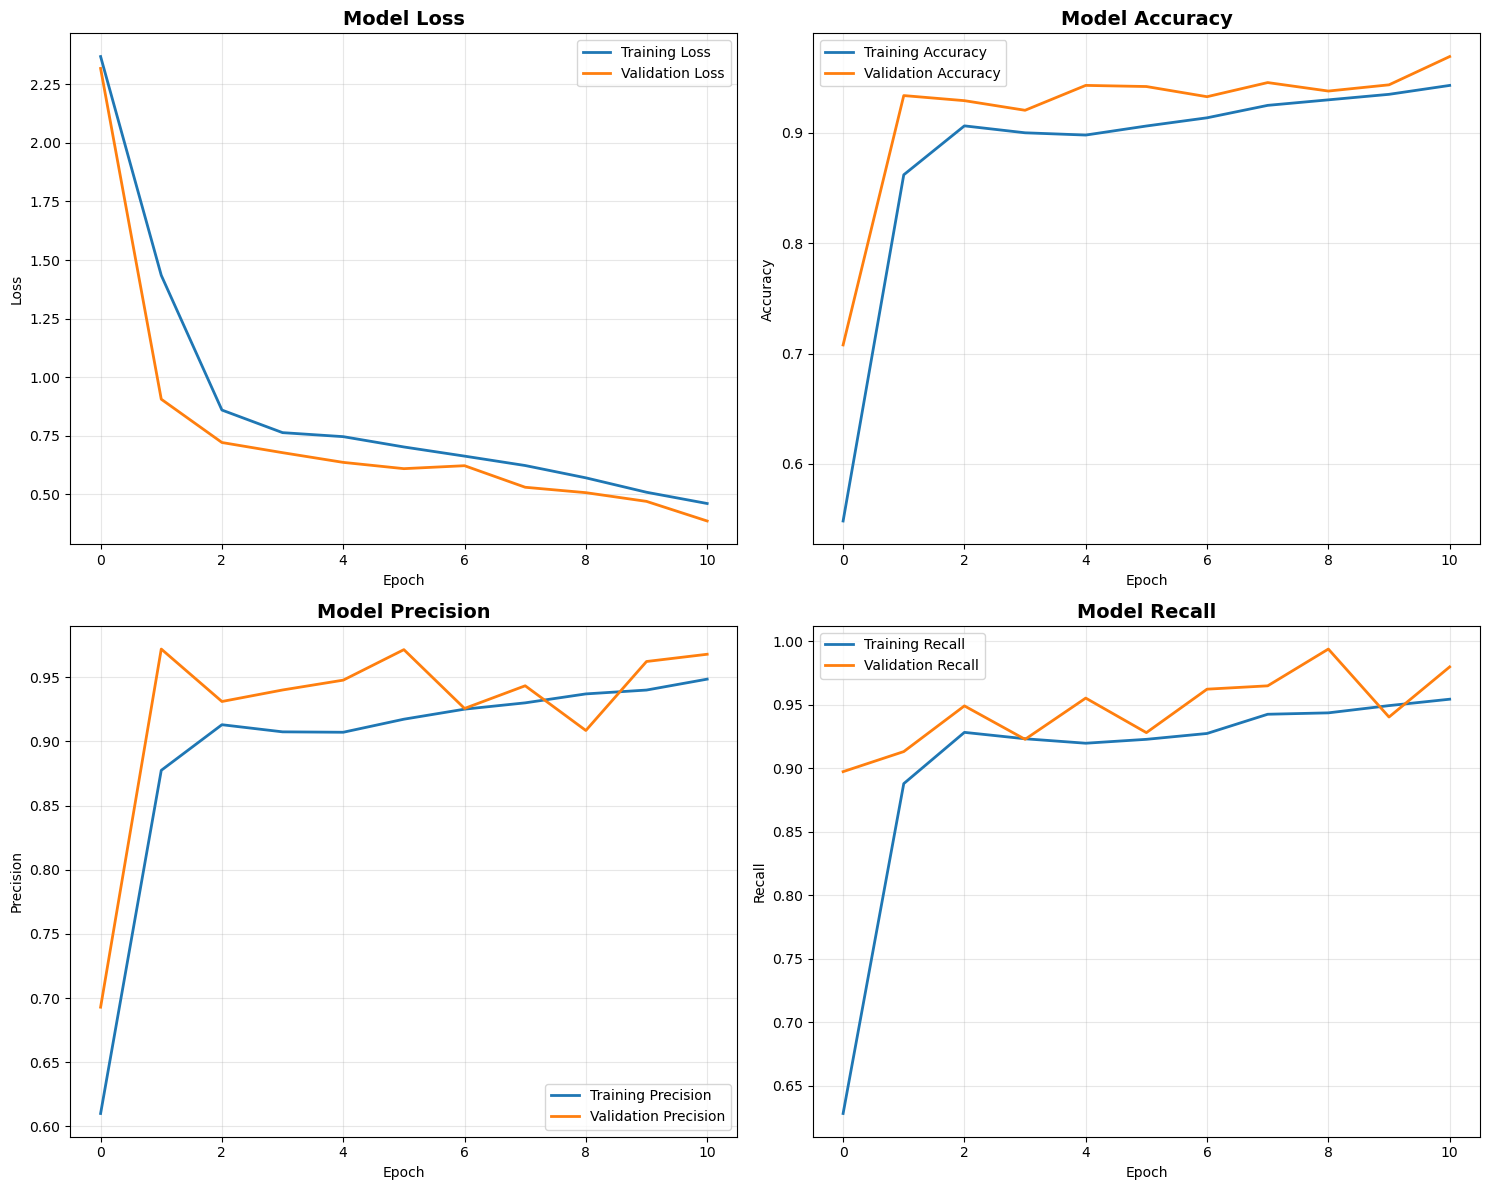

In [23]:
from sklearn import metrics

# Calculate F1 Score using the precision and recall from model evaluation
# Formula: F1 = 2 * (precision * recall) / (precision + recall)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"F1 Score: {f1_score:.4f}")  # Print formatted to 4 decimal places

# Generate model predictions on test set
print("Generating predictions...")
# Get probability predictions for each test sample (batch processing for efficiency)
y_pred_prob = model.predict(X_test, batch_size=BATCH_SIZE)
# Convert probabilities to binary predictions (threshold=0.5) and flatten to 1D array
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Create confusion matrix visualization
cm = metrics.confusion_matrix(y_test, y_pred)  # Compute confusion matrix
plt.figure(figsize=(10, 8))  # Set figure size (width, height in inches)

# Create heatmap visualization of confusion matrix
sns.heatmap(
    cm,                      # Confusion matrix data
    annot=True,              # Show values in each cell
    fmt='d',                 # Format as integers
    cmap='Blues',           # Blue color gradient
    xticklabels=['NonViolence', 'Violence'],  # x-axis class labels
    yticklabels=['NonViolence', 'Violence']   # y-axis class labels
)

# Add title and axis labels with custom styling
plt.title('Confusion Matrix - MobileNetV2 + TSM Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Save high-quality version of the plot (300dpi)
plt.savefig('images/confusion_matrix_tsm.png', dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Print detailed classification report
print("\nClassification Report:")
# Includes precision, recall, f1-score, and support for each class
print(metrics.classification_report(
    y_test, 
    y_pred, 
    target_names=['NonViolence', 'Violence']  # Custom class names
))

# Call previously defined function to plot training history metrics
plot_training_history(history)

## Test Prediction on a Sample Video

In [24]:
# Test model loading functionality
print("\nTesting model loading...")

# Attempt to load the saved model with error handling
try:
    # Load the saved Keras model with custom layer definition
    # model_save_path: Path to saved model file
    # custom_objects: Dictionary mapping custom layer names to their classes
    loaded_model = keras.models.load_model(
        model_save_path,
        custom_objects={'TemporalShift': TemporalShift}  # Required for custom layers
    )
    print("Model loaded successfully!")

    # Perform a quick test prediction if test data exists
    if len(X_test) > 0:  # Check if test data is available
        # Take first sample from test set
        test_sample = X_test[:1]  # Get first test sample (batch of 1)
        
        # Make prediction (returns 2D array: [batch][probability])
        prediction = loaded_model.predict(test_sample)[0][0]  # Extract probability
        actual = y_test[0]  # Get corresponding true label
        
        # Print prediction results with formatting
        print(f"Test prediction: {prediction:.4f} (threshold: 0.5)")
        print(f"Predicted class: {'Violence' if prediction > 0.5 else 'NonViolence'}")
        print(f"Actual class: {'Violence' if actual == 1 else 'NonViolence'}")

# Handle potential loading errors        
except Exception as e:
    print(f"Error loading model: {e}")

# Print completion summary
print("\nTraining completed successfully!")
print(f"Model saved as: {model_save_path}")  # Full model path
print(f"Best weights saved as: {checkpoint_path}")  # Best weights path
print("Check the 'images' directory for visualization plots.")  # Where to find visualizations
print("Check the 'logs' directory for TensorBoard logs.")  # Where to find training logs


Testing model loading...
Model loaded successfully!
1/1 [==============================] - 1s 1s/step
Test prediction: 0.9993 (threshold: 0.5)
Predicted class: Violence
Actual class: Violence

Training completed successfully!
Model saved as: model/mobilenetv2_tsm_model.h5
Best weights saved as: model/best_mobilenetv2_tsm_weights.h5
Check the 'images' directory for visualization plots.
Check the 'logs' directory for TensorBoard logs.


In [25]:
# Print a visual separator and section header
print("\n" + "="*50)  # New line followed by 50 '=' characters
print("MODEL ARCHITECTURE SUMMARY")  # Section title
print("="*50)  # Closing separator (50 '=' characters)

# Print input tensor dimensions using constants
# Format: (temporal_frames, height, width, channels)
print(f"Input Shape: ({SEQUENCE_LENGTH}, {IMG_SIZE}, {IMG_SIZE}, {ColorChannels})")

# Base feature extraction architecture
print(f"Feature Extractor: MobileNetV2 (ImageNet pretrained)")

# Temporal modeling components
print(f"Temporal Modeling: TSM (Temporal Shift Module) + Conv1D")

# TSM specific configuration
print(f"TSM Shift Ratio: {TSM_SHIFT_RATIO}")  # Portion of channels to shift

# Attention mechanism used
print(f"Attention Mechanism: Channel-wise attention")

# Regularization techniques applied
print(f"Regularization: Dropout, L2 regularization, Batch normalization")

# Total trainable parameters with thousand separators
print(f"Total Parameters: {model.count_params():,}")  # Format with commas

# Final visual separator
print("="*50)


MODEL ARCHITECTURE SUMMARY
Input Shape: (8, 64, 64, 3)
Feature Extractor: MobileNetV2 (ImageNet pretrained)
Temporal Modeling: TSM (Temporal Shift Module) + Conv1D
TSM Shift Ratio: 0.25
Attention Mechanism: Channel-wise attention
Regularization: Dropout, L2 regularization, Batch normalization
Total Parameters: 6,360,393
